In [1]:
%reload_ext autoreload
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns


import math

from IPython.display import display, HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [47]:
print mnist.train.images.shape
print mnist.train.labels.shape

(55000, 784)
(55000,)


In [4]:

Xtrain_ = mnist.train.images[np.logical_or(mnist.train.labels == 0, mnist.train.labels == 1), :] 
Ytrain = mnist.train.labels[np.logical_or(mnist.train.labels == 0, mnist.train.labels == 1)]

Xtest_ = mnist.test.images[np.logical_or(mnist.test.labels == 0, mnist.test.labels == 1), :]
Ytest = mnist.test.labels[np.logical_or(mnist.test.labels == 0, mnist.test.labels == 1)]

print Xtrain_.shape, Ytrain.shape
print Xtest_.shape, Ytest.shape

(11623, 784) (11623,)
(2115, 784) (2115,)


In [5]:
p_perturb = 0.7
v_perturb = 0.9

pert_train = np.random.binomial(1, p_perturb, size=(11623, 784))
Xtrain = np.clip(Xtrain_ * (1 - pert_train) + np.random.uniform(high=v_perturb, size=(11623, 784)) * pert_train, 0, 1)

pert_test = np.random.binomial(1, p_perturb, size=(2115, 784))
Xtest = np.clip(Xtest_ * (1 - pert_test) + np.random.uniform(high=v_perturb, size=(2115, 784)) * pert_test, 0, 1)

import gc

del pert_train, pert_test

gc.collect()

0

<IPython.core.display.Javascript object>


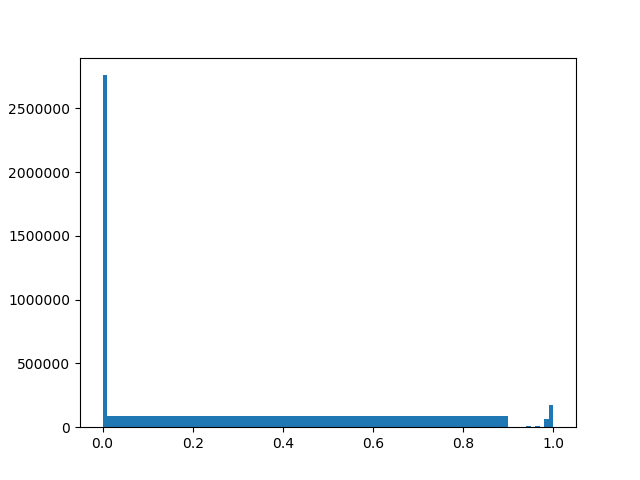

In [6]:
plt.figure()
plt.hist(np.concatenate([Xtrain.ravel(), Xtest.ravel()]), bins=100)
plt.show()

<IPython.core.display.Javascript object>


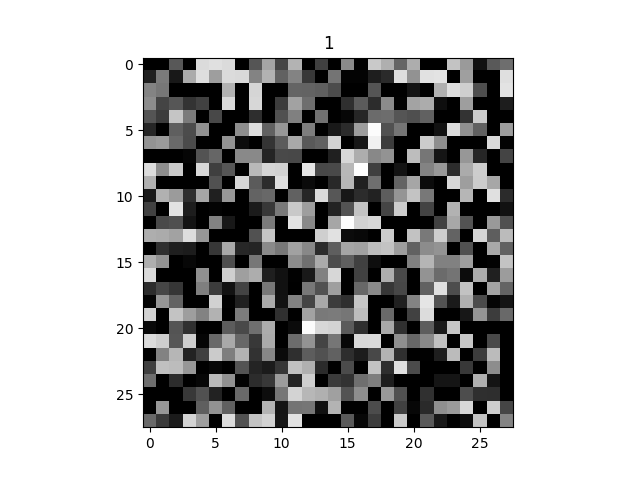

<IPython.core.display.Javascript object>


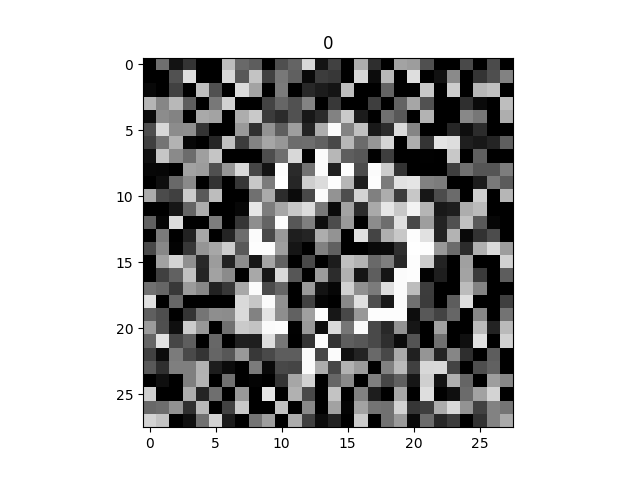

<IPython.core.display.Javascript object>


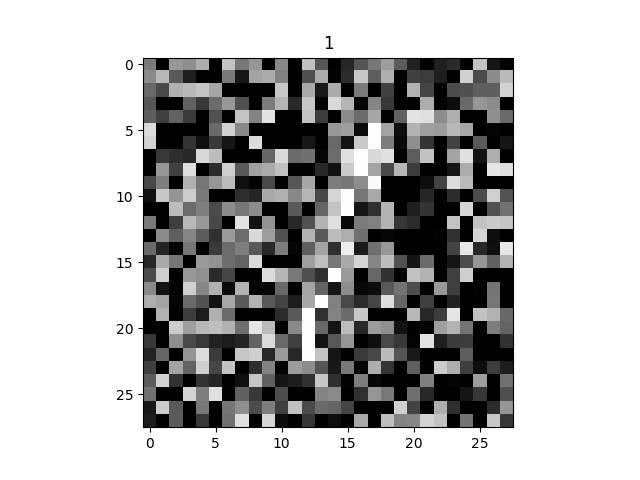

<IPython.core.display.Javascript object>


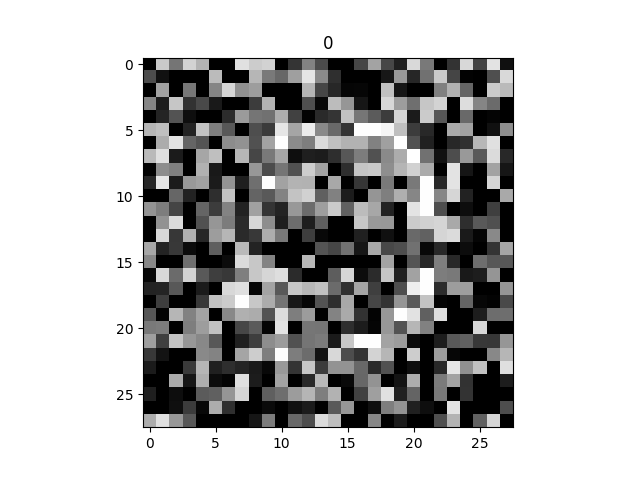

<IPython.core.display.Javascript object>


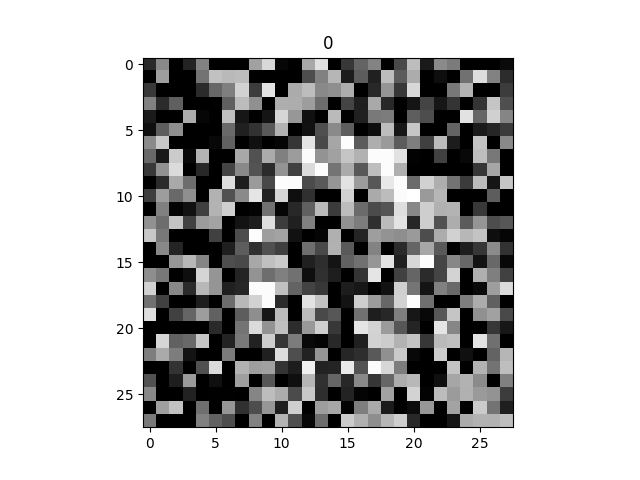

<IPython.core.display.Javascript object>


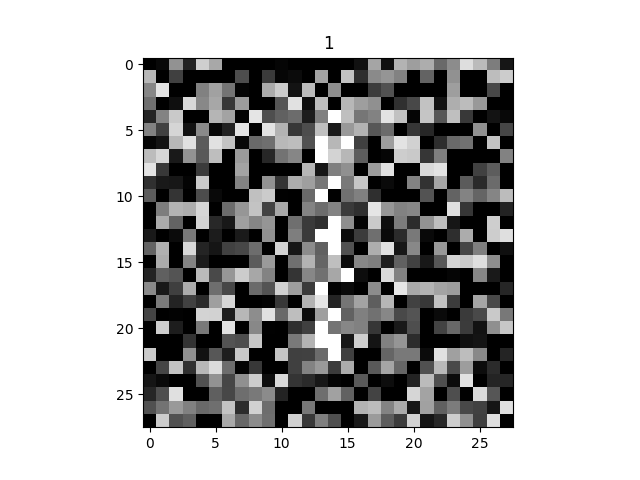

<IPython.core.display.Javascript object>


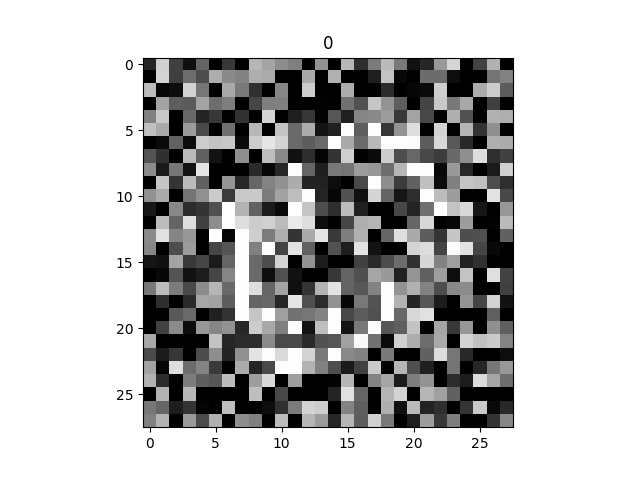

<IPython.core.display.Javascript object>


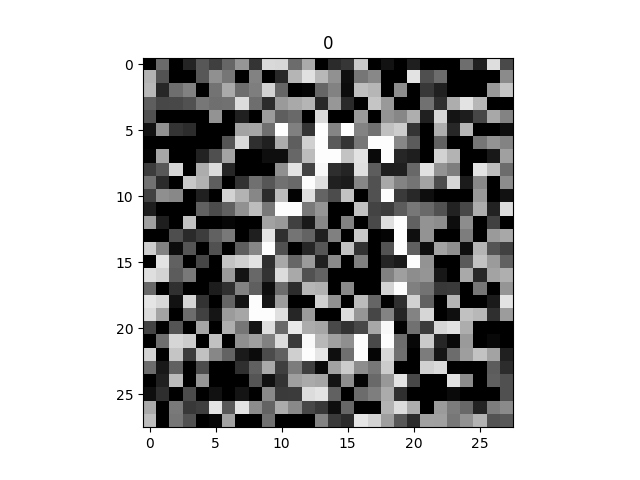

<IPython.core.display.Javascript object>


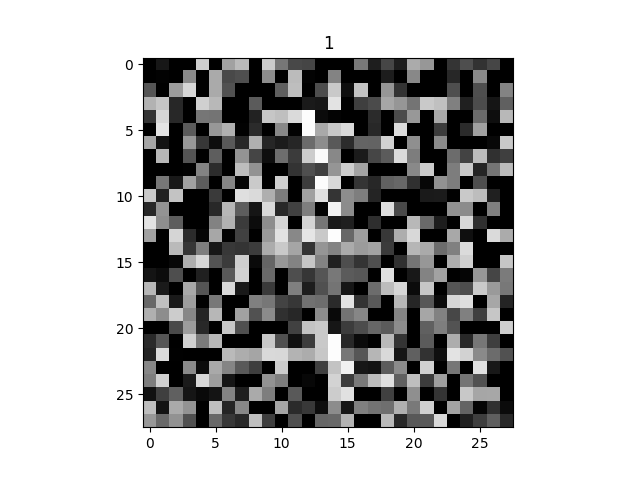

<IPython.core.display.Javascript object>


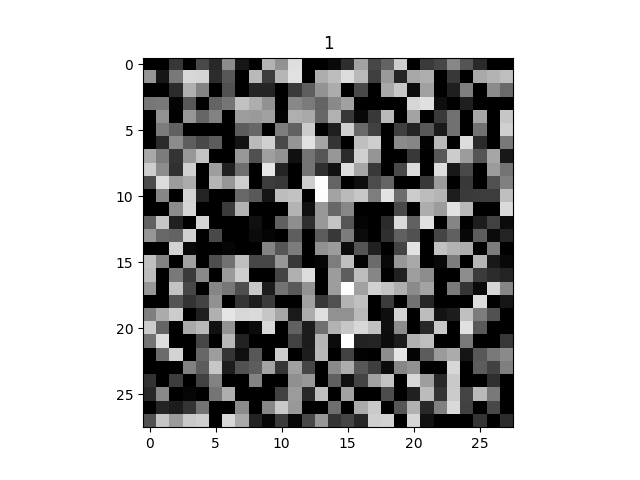

In [7]:
for i in xrange(10):
    plt.figure()
    plt.imshow(Xtest[i, :].reshape((28, 28)), cmap='gray', vmin=0, vmax=1)
    plt.title("%s" % Ytest[i])
    plt.show()

In [8]:
from __future__ import division


from __future__ import division
import tensorflow as tf



def logistic_full_gd(X_, Y_, lr, w_init, n_iter):
    lr = float(lr)
    
    n, p = X_.shape
    
#     print n, p

    
    
    X = tf.placeholder(tf.float64, [None, p])
    
    Y = tf.placeholder(tf.float64, [None, 1])
    
    w = tf.Variable(initial_value=w_init.reshape((-1, 1)), dtype=tf.float64)

#     print(w)
    
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.matmul(X, w), labels=Y))
    
    
    opt = tf.train.GradientDescentOptimizer(lr).minimize(loss)
    
    init = tf.global_variables_initializer()
    
    
    with tf.Session() as sess:
        sess.run(init)
        
        for _ in xrange(n_iter):
            
            
            sess.run([opt], feed_dict={X: X_, Y: Y_.reshape((-1, 1))})
            
        what = np.array(w.eval(session=sess)).ravel()
        
    return what

In [9]:
from sklearn import preprocessing

In [10]:
scaler = preprocessing.StandardScaler().fit(Xtrain)

In [11]:
import statsmodels.api as sm

/scratch/cluster/lty/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [12]:
what = logistic_full_gd(sm.add_constant(scaler.transform(Xtrain), prepend=False, has_constant='add'), \
                        Ytrain, 10, np.zeros((785,)), 10000)

In [13]:
print np.mean(Ytest != (sm.add_constant(scaler.transform(Xtest), prepend=False, has_constant='add').dot(what) > 0))

0.00851063829787


<IPython.core.display.Javascript object>


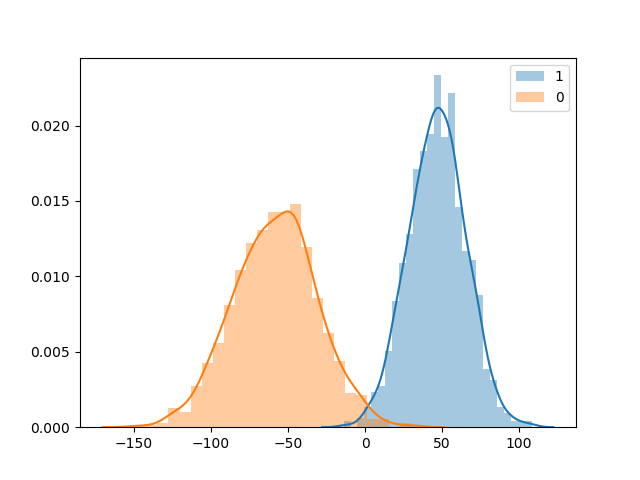

In [14]:
plt.figure()

sns.distplot(sm.add_constant(scaler.transform(Xtest[Ytest == 1]), prepend=False, has_constant='add').dot(what), \
             label="1")

sns.distplot(sm.add_constant(scaler.transform(Xtest[Ytest == 0]), prepend=False, has_constant='add').dot(what), \
             label="0")

plt.legend()

In [15]:
def get_adversarial_perturb(images_, w_, b_, Y_):
    n, p = images_.shape
    
    images = tf.placeholder(tf.float64, [None, p])
    
    ap = tf.Variable(initial_value=np.zeros((1, p)), dtype=tf.float64)
    
    w = tf.placeholder(tf.float64, [p, 1])
    b = tf.placeholder(tf.float64, [1,])
    Y = tf.placeholder(tf.float64, [None, 1])
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.matmul(images + ap, w) + b, labels=Y))
    
    opt = tf.train.GradientDescentOptimizer(0)
    
    
    loss_grads_and_vars = opt.compute_gradients(loss, [ap])
    image_grad_tf = loss_grads_and_vars[0][0]
    
    
    init = tf.global_variables_initializer()
    
    
    with tf.Session() as sess:
        sess.run(init)
        
        image_grad = sess.run(image_grad_tf, \
                              feed_dict={w: w_.reshape((-1, 1)), b: [b_], \
                                         Y: Y_.reshape((-1, 1)), \
                                         images: images_, \
                                        }).ravel()
        
    return image_grad

In [56]:
ap = get_adversarial_perturb(scaler.transform(Xtest), what[:-1], what[-1], Ytest)

In [57]:
print sm.add_constant(scaler.transform(Xtest[1, :].reshape((1, -1))), \
                      has_constant="add", prepend=False).dot(what)

[-67.03826095]


In [94]:
mult_perturb = 6e1
img_perturb = scaler.transform(Xtest[1, :].reshape((1, -1))) + mult_perturb * ap.reshape((1, -1))

print sm.add_constant(img_perturb, \
                      has_constant="add", prepend=False).dot(what)

[ 1.21243545]


<IPython.core.display.Javascript object>


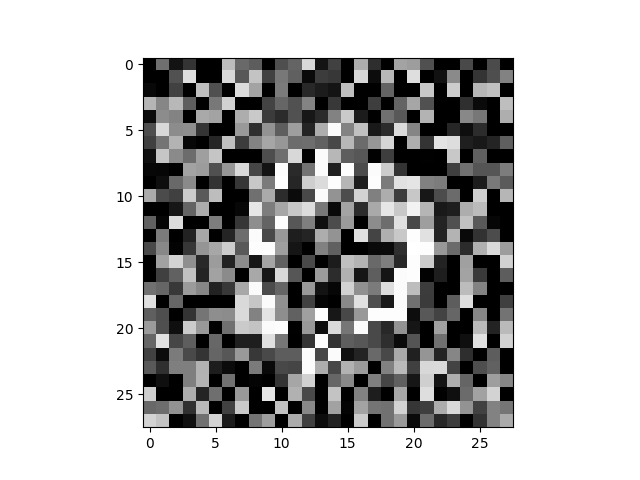

In [95]:
plt.figure()
plt.imshow(Xtest[1, :].reshape((28, 28)), cmap="gray", vmin=0, vmax=1)

<IPython.core.display.Javascript object>


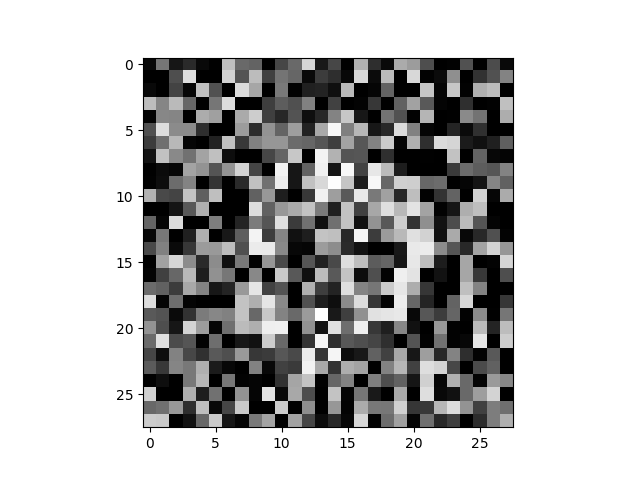

In [96]:
plt.figure()
plt.imshow((img_perturb.ravel() * scaler.scale_ + scaler.mean_).reshape((28, 28)), cmap="gray", vmin=0, vmax=1)

<IPython.core.display.Javascript object>


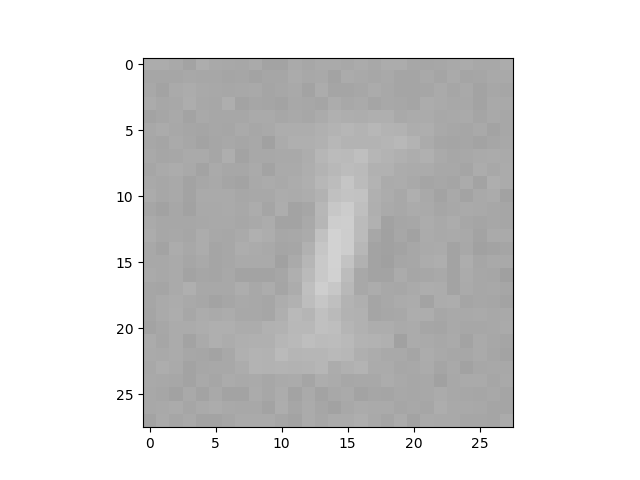

In [97]:
plt.figure()
plt.imshow(((mult_perturb * ap) * scaler.scale_ + scaler.mean_).reshape((28, 28)), cmap="gray", vmin=-1, vmax=1)

In [98]:
cond_good = np.abs(sm.add_constant(scaler.transform(Xtest), prepend=False, has_constant="add").dot(what)) < 6
print np.mean(cond_good)

0.0156028368794


In [99]:
idx_good = np.where(cond_good > 0)[0]

In [100]:
print idx_good.tolist()

[99, 120, 150, 216, 244, 287, 425, 454, 558, 626, 627, 818, 839, 843, 877, 992, 1036, 1060, 1068, 1244, 1375, 1388, 1397, 1507, 1664, 1740, 1857, 1952, 2037, 2044, 2105, 2106, 2107]


In [101]:
for i in idx_good.tolist():
    print i, Ytest[i], ",", 
    

99 0 , 120 0 , 150 0 , 216 1 , 244 0 , 287 0 , 425 0 , 454 1 , 558 0 , 626 1 , 627 0 , 818 0 , 839 0 , 843 1 , 877 1 , 992 0 , 1036 1 , 1060 1 , 1068 0 , 1244 1 , 1375 0 , 1388 0 , 1397 1 , 1507 0 , 1664 1 , 1740 0 , 1857 1 , 1952 0 , 2037 1 , 2044 0 , 2105 1 , 2106 1 , 2107 0 ,


<IPython.core.display.Javascript object>


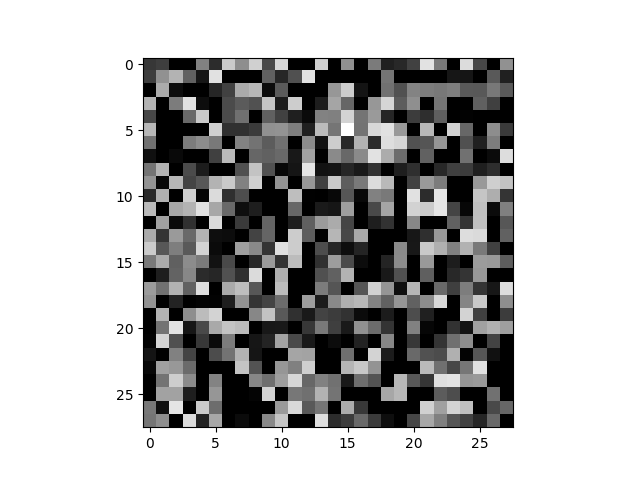

In [102]:
plt.figure()
plt.imshow(Xtest[1370, :].reshape((28, 28)), cmap="gray", vmin=0, vmax=1)

In [103]:


def logit2prob(x):
    return np.exp(-np.logaddexp(0, x))

In [105]:
print logit2prob(10)
print logit2prob(1.2)

4.53978687024e-05
0.231475216501


In [106]:

from __future__ import division


from __future__ import division
import tensorflow as tf



def sgd_avg_infer(X_, Y_, lr, 
                  size_batch, 
                  w_init, 
                  burn_in, n_avg, n_skip, n_sample):
    lr = float(lr)
    
    n, p = X_.shape
    
#     print n, p

    
    
    X = tf.placeholder(tf.float64, [None, p])
    
    Y = tf.placeholder(tf.float64, [None, 1])
    
    w = tf.Variable(initial_value=w_init.reshape((-1, 1)), dtype=tf.float64)

#     print(w)
    
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.matmul(X, w), labels=Y))
    
    
    opt = tf.train.GradientDescentOptimizer(lr).minimize(loss)
    
    init = tf.global_variables_initializer()
    
    
    
    n_iter = burn_in + (n_avg + n_skip) * n_sample + 3
    
    
    w_avg_samples = []
    
    w_all = []
    
    with tf.Session() as sess:
        sess.run(init)
        
        for i_ in xrange(n_iter):
            ind_batch = np.random.choice(n, size=size_batch, replace=True)
            
            Xb = X_[ind_batch, :].reshape((-1, p))
            Yb = Y_[ind_batch].reshape((-1, 1))
            
            sess.run([opt], feed_dict={X: Xb, Y: Yb})
            
            if i_ >= burn_in:
                if (i_ - burn_in) % (n_avg + n_skip) < n_avg:
                    wb = w.eval(session=sess).ravel().tolist()
                    w_avg_samples.append(wb)
                elif (i_ - burn_in) % (n_avg + n_skip) == n_avg:
                    w_avg_samples = np.array(w_avg_samples)
                    w_avg = np.mean(w_avg_samples, axis=0)
                    w_all.append(w_avg.ravel().tolist())
                    w_avg_samples = []
    
    return np.array(w_all)  





In [30]:
lr = 10
size_batch = 3000
w_init = what
burn_in = 1000
n_avg = 1000
n_skip = 1000
n_sample = 100

w_sgd = sgd_avg_infer(sm.add_constant(scaler.transform(Xtrain), prepend=False, has_constant="add"), \
                     Ytrain, lr, \
                     size_batch, w_init, burn_in, n_avg, n_skip, n_sample)

In [31]:
print np.mean(Ytest \
              != \
              (sm.add_constant(scaler.transform(Xtest), \
                               prepend=False, \
                               has_constant='add').dot(np.average(w_sgd, axis=0)) > 0))

0.00898345153664


In [32]:
from __future__ import division

import math

n, _ = Xtrain.shape

w_sgd_avg = np.mean(w_sgd, axis=0)

w_inf = w_sgd_avg + math.sqrt(n_avg * size_batch / n) * (w_sgd - w_sgd_avg)

In [107]:
print np.mean(Ytest \
              != \
              (sm.add_constant(scaler.transform(Xtest), \
                               prepend=False, \
                               has_constant='add').dot(np.average(w_inf, axis=0)) > 0))

0.00898345153664


<IPython.core.display.Javascript object>


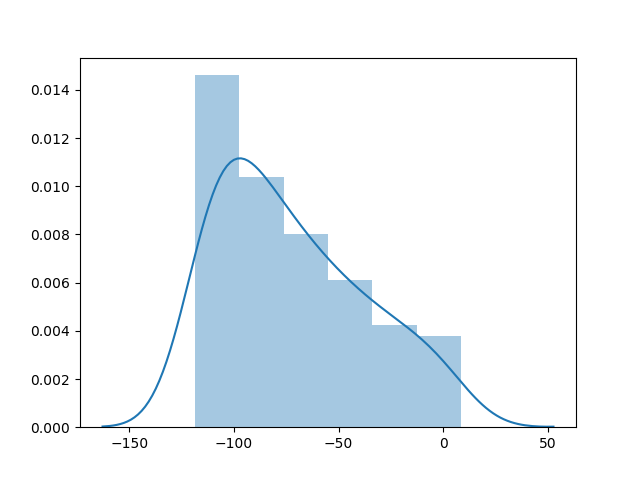

In [111]:
plt.figure()
sns.distplot(w_inf[:, :-1].dot(scaler.transform(Xtest[1, :].reshape((1, -1))).ravel()) + w_inf[:, -1])


In [112]:
print np.mean(w_inf[:, :-1].dot(scaler.transform(Xtest[1, :].reshape((1, -1))).ravel()) + w_inf[:, -1])

-72.2112677001


In [113]:
print what[:-1].dot(scaler.transform(Xtest[1, :].reshape((1, -1))).ravel()) + what[-1]

-67.0382609539


<IPython.core.display.Javascript object>


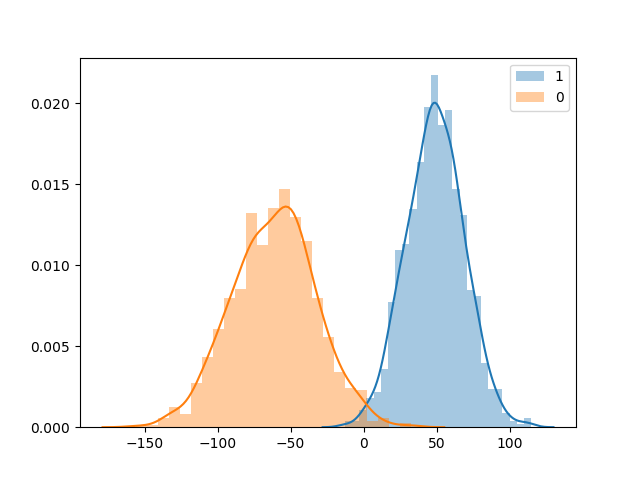

In [114]:
plt.figure()

sns.distplot(sm.add_constant(scaler.transform(Xtest[Ytest == 1]), prepend=False, has_constant='add').dot(np.average(w_inf, axis=0)), \
             label="1")

sns.distplot(sm.add_constant(scaler.transform(Xtest[Ytest == 0]), prepend=False, has_constant='add').dot(np.average(w_inf, axis=0)), \
             label="0")

plt.legend()

<IPython.core.display.Javascript object>


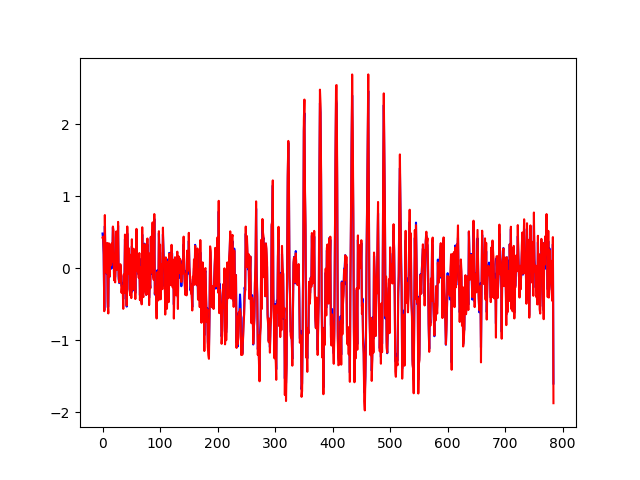

In [115]:
plt.figure()
plt.plot(what, 'b', label="GD")
plt.plot(np.average(w_inf, axis=0), 'r', label="SGD")

<IPython.core.display.Javascript object>


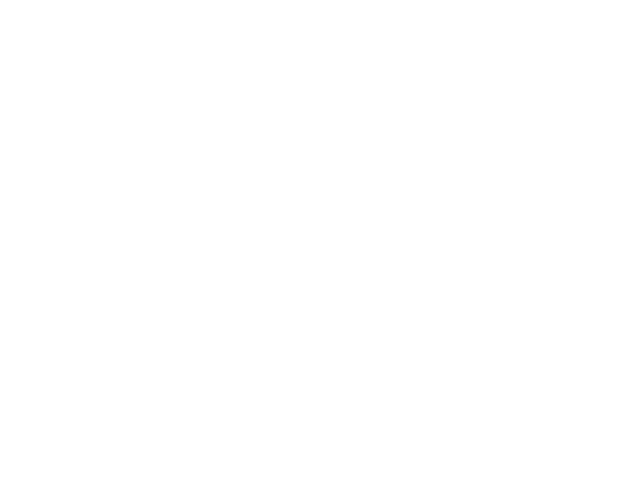

<IPython.core.display.Javascript object>


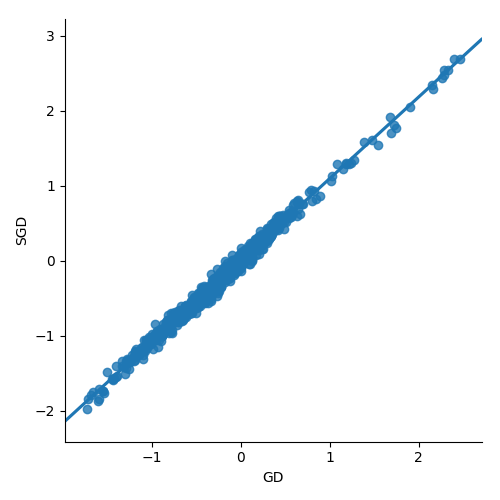

In [117]:
plt.figure()
sns.lmplot(x="GD", y="SGD", data=pd.DataFrame({"GD": what, "SGD": np.average(w_inf, axis=0)}))

In [121]:
scipy.stats.pearsonr(what, w_sgd_avg)

(0.99524814863811062, 0.0)

In [122]:
# ap = get_adversarial_perturb(scaler.transform(Xtrain), w_sgd_avg[:-1], w_sgd_avg[-1], Ytrain)

In [123]:
# mult_perturb = 5e26
# img_perturb = scaler.transform(Xtest[0, :].reshape((1, -1))) - mult_perturb * ap.reshape((1, -1))

print sm.add_constant(img_perturb, \
                      has_constant="add", prepend=False).dot(w_sgd_avg)

[ 1.54968335]


In [124]:
# plt.figure()
# plt.imshow(Xtest[1, :].reshape((28, 28)), cmap="gray", vmin=0, vmax=1)

# plt.figure()
# plt.imshow((img_perturb.ravel() * scaler.scale_ + scaler.mean_).reshape((28, 28)), cmap="gray", vmin=0, vmax=1)

# plt.figure()
# plt.imshow(((mult_perturb * ap) * scaler.scale_ + scaler.mean_).reshape((28, 28)), cmap="gray", vmin=-1, vmax=1)

<IPython.core.display.Javascript object>


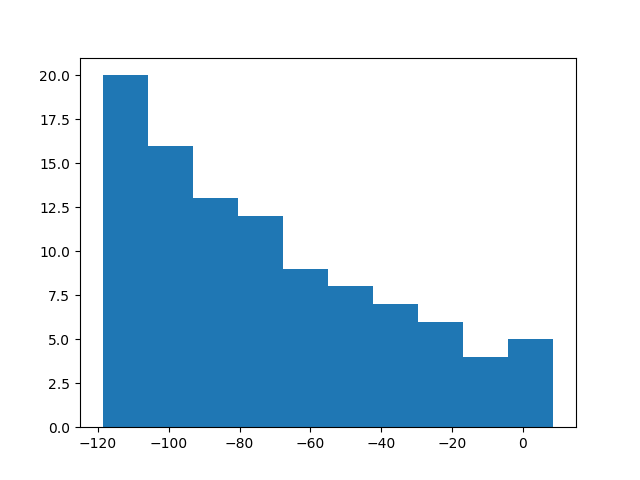

(array([ 20.,  16.,  13.,  12.,   9.,   8.,   7.,   6.,   4.,   5.]),
 array([-118.67927186, -105.94989834,  -93.22052482,  -80.4911513 ,
         -67.76177778,  -55.03240426,  -42.30303074,  -29.57365722,
         -16.8442837 ,   -4.11491018,    8.61446334]),
 <a list of 10 Patch objects>)

In [125]:
plt.figure()
plt.hist(w_inf[:, :-1].dot(scaler.transform(Xtest[1, :].reshape((1, -1))).ravel()) + w_inf[:, -1])


In [126]:
print np.percentile(w_inf[:, :-1].dot(img_perturb.ravel()) + w_inf[:, -1], \
                   [2.5, 97.5])

[-1.77578636  5.08962493]


In [127]:
print np.percentile(w_inf[:, :-1].dot(scaler.transform(Xtest[1, :].reshape((1, -1))).ravel()) + w_inf[:, -1], \
                   [2.5, 97.5])

[-117.11544966    0.75614864]


<IPython.core.display.Javascript object>


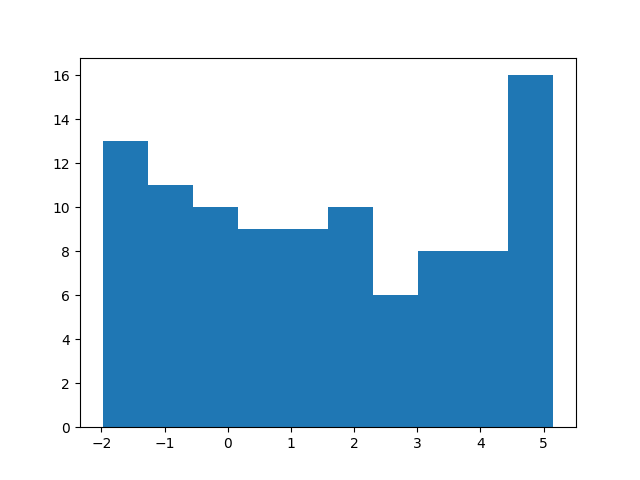

(array([ 13.,  11.,  10.,   9.,   9.,  10.,   6.,   8.,   8.,  16.]),
 array([-1.98094784, -1.26733909, -0.55373035,  0.15987839,  0.87348714,
         1.58709588,  2.30070462,  3.01431337,  3.72792211,  4.44153085,
         5.15513959]),
 <a list of 10 Patch objects>)

In [128]:
plt.figure()
plt.hist(w_inf[:, :-1].dot(img_perturb.ravel()) + w_inf[:, -1])
